## Stack design

This example notebook shows how to supply parameters to a TEA class, how to plot mass- and volume loadings, how to estimate energy and how to loop over different parameter settings.

Though, usally only active material and electrolyte densities are required inputs for the loadings plot with PyBaMM parameter-sets, the electrode stack can also be designed from the bottom up.

Let's generate two TEA classes with and without a PyBaMM parameter-set.

Base parameter-set


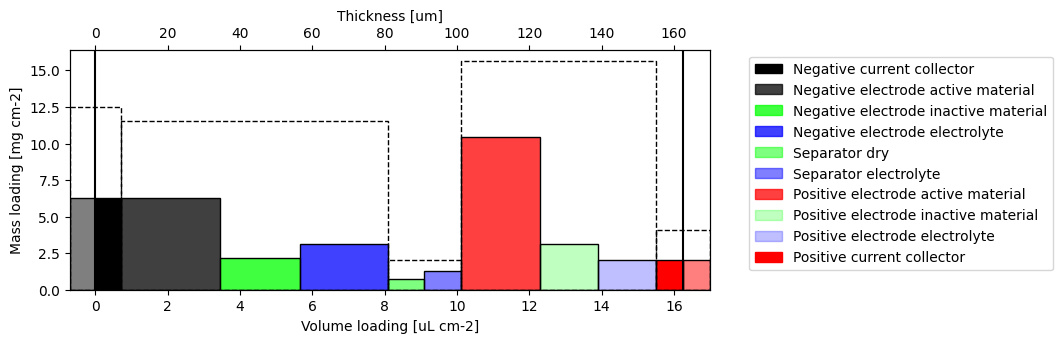

                                      Volume loading [uL.cm-2]  \
Negative electrode electrolyte                        2.434600   
Negative electrode active material                    2.755782   
Negative electrode inactive material                  2.209618   
Negative electrode dry                                7.400000   
Negative electrode                                    7.400000   
Positive electrode electrolyte                        1.598400   
Positive electrode active material                    2.204928   
Positive electrode inactive material                  1.596672   
Positive electrode dry                                5.400000   
Positive electrode                                    5.400000   
Separator electrolyte                                 1.016000   
Separator dry                                         0.984000   
Separator                                             2.000000   
Negative current collector                            1.400000   
Positive c

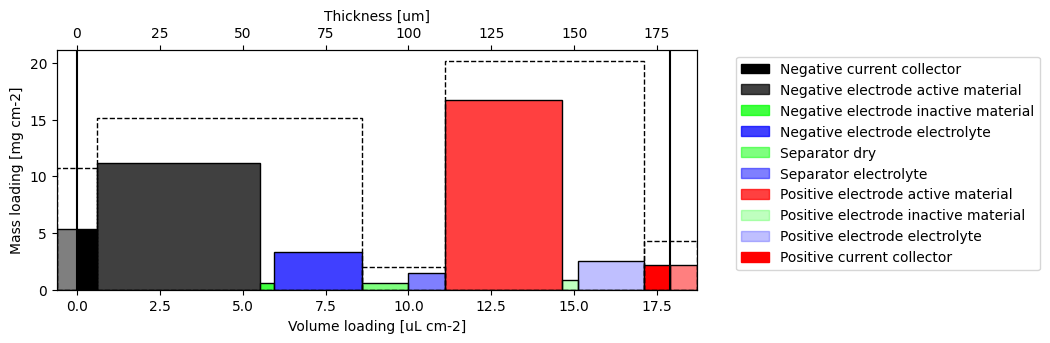

,Volume loading [uL.cm-2],Mass loading [mg.cm-2],Density [mg.uL-1]
Negative electrode electrolyte,2.640000,3.368640,1.276000
Negative electrode active material,4.925607,11.161425,2.266000
Negative electrode inactive material,0.434393,0.587443,1.352332
Negative electrode dry,8.000000,11.748869,1.468609
Negative electrode,8.000000,15.117509,1.889689
Positive electrode electrolyte,1.980000,2.526480,1.276000
Positive electrode active material,3.529756,16.766341,4.750000
Positive electrode inactive material,0.490244,0.882439,1.800000
Positive electrode dry,6.000000,17.648780,2.941463
Positive electrode,6.000000,20.175260,3.362543


In [1]:
#%pip install pybamm
import pybamm
from pybamm_tea import tea
import numpy as np
import matplotlib.pyplot as plt

# define a PyBaMM based parameter-set
param_base = pybamm.ParameterValues("Ecker2015")
input_base = {
    "Electrolyte density [kg.m-3]": 1276, # LiPF6 in EC:EMC 3:7 + 2% VC
    "Negative electrode active material density [kg.m-3]": 2266, # Graphite
    "Positive electrode active material density [kg.m-3]": 4750, # NMC604
}

input_only = {
    # Negative electrode
    "Negative electrode thickness [m]": 80e-6,
    "Negative electrode porosity": 0.33,
    "Negative electrode active material density [kg.m-3]": 2266, # Graphite
    "Negative electrode binder density [kg.m-3]": (2 * 940 + 1600) / 3, # 2:1 CMC:SBR
    "Negative electrode conductive additive density [kg.m-3]": 1800, # CB
    "Negative electrode binder dry mass fraction": 0.03,
    "Negative electrode conductive additive dry mass fraction": 0.02,
    "Negative electrode non-stoichiometric loss of capacity": 0.05, # reduces initial maximal concentration/capacity
    "Negative electrode active material capacity [mAh.g-1]": 372, # theoretical capacity (to be limited by stoichiometric limits)
    "Negative electrode minimum stoichiometry": 0.02, # Graphite
    "Negative electrode maximum stoichiometry": 0.90, # Graphite
    "Negative electrode average OCP [V]": 0.1, # Graphite - dependent on stoichiometry limits if not set

    # Separator and electrolyte
    "Separator thickness [m]": 25e-6,
    "Separator porosity": 0.45,
    "Separator dry density [kg.m-3]": 400, # PP/PE
    "Electrolyte density [kg.m-3]": 1276, # LiPF6 in EC:EMC 3:7 + 2% VC

    # Positive electrode
    "Positive electrode thickness [m]": 60e-6,
    "Positive electrode porosity": 0.33,
    "Positive electrode active material density [kg.m-3]": 4750, # NMC604
    "Positive electrode inactive material density [kg.m-3]": 1800, # PVDF and CB
    "Positive electrode active material dry mass fraction": 0.95,
    "Positive electrode active material capacity [mAh.g-1]": 200, # theoretical capacity (to be limited by stoichiometric limits)
    "Positive electrode minimum stoichiometry": 0.25, # Graphite
    "Positive electrode maximum stoichiometry": 0.90, # Graphite
    "Positive electrode average OCP [V]" : 4.2, # NMC604

    # Current collectors
    "Negative current collector thickness [m]": 12e-6,
    "Negative current collector density [kg.m-3]": 8960, # Cu
    "Positive current collector thickness [m]": 16e-6,
    "Positive current collector density [kg.m-3]": 2700, # Al
}

# create TEA objects
tea_base = tea.TEA(param_base, input_base) # base parameter-set (Ecker2015)
tea_input_only = tea.TEA(input_only)
# tea_pybamm = tea.TEA(param_pybamm, input_only) would overwrite base parameter and its derivates

# plot stack breakdown and print stack breakdown dataframe for base parameter-set
print("Base parameter-set")
tea_base.plot_stack_breakdown()
print(tea_base.stack_breakdown_dataframe)
# plot stack breakdown and return stack breakdown dataframe for input only
print("Input only")
tea_input_only.plot_stack_breakdown()
tea_input_only.stack_breakdown_dataframe

Let's now see how energy densities might evolve with the electrode thicknesses.
Note, that the stack-level volumetric energy density is calculated without considering transport and reaction overpotentials / area-specific impedances, as below.
\begin{equation}
E_{\text {stack }}^{\text {volumetric }}=\frac{\min \left(q_{\text {area }}^{+}, q_{\text {area }}^{-}\right)\left(\bar{U}_{+}-\bar{U}_{-}\right)}{\frac{d_{c c}^{-}}{2}+d_{-}+d_{\text {separator }}+d_{+}+\frac{d_{c c}^{+}}{2}}
\end{equation}
The gravimetric energy density is then obtained by dividing with the stack density. Without knowledge of the the actual housing geometry, electrode areas and so on, cell-level energy densities could be estimated with given constant form factors.

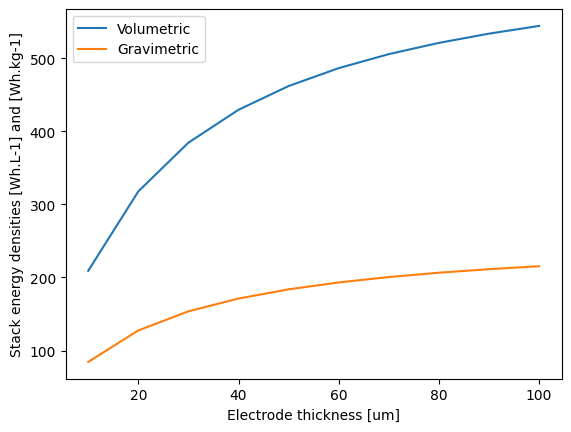

{'Negative electrode minimum stoichiometry': 0.02, 'Negative electrode maximum stoichiometry': 0.9, 'Positive electrode minimum stoichiometry': 0.25, 'Positive electrode maximum stoichiometry': 0.9, 'Negative electrode capacity [mA.h.cm-2]': 4.930559655699846, 'Positive electrode capacity [mA.h.cm-2]': 4.471024390243902, 'Negative electrode practical capacity [mA.h.cm-2]': 4.338892497015864, 'Positive electrode practical capacity [mA.h.cm-2]': 2.9061658536585364, 'Practical n/p ratio': 1.4929954846017084, 'Capacity [mA.h.cm-2]': 2.9061658536585364, 'Negative electrode average OCP [V]': 0.1, 'Positive electrode average OCP [V]': 4.2, 'Stack average OCP [V]': 4.1000000000000005, 'Stack thickness [m]': 0.00021900000000000004, 'Volumetric stack capacity [Ah.L-1]': 132.7016371533578, 'Volumetric stack energy density [Wh.L-1]': 544.076712328767, 'Stack density [kg.m-3]': 2525.969558254345, 'Negative current collector density [kg.m-3]': 8960, 'Negative electrode density [kg.m-3]': 1889.688600

In [2]:
# generate an array of thicknesses from 10e-6 to 100e-6
thicknesses = np.linspace(10e-6, 100e-6, 10)
# loop over thicknesses and create an array with calculated stack energy densities for each
stack_volumetric_energy_densities = []
stack_gravimetric_energy_densities = []
for thickness in thicknesses:
    input_only["Negative electrode thickness [m]"] = thickness
    input_only["Positive electrode thickness [m]"] = thickness*0.8
    tea_loop = tea.TEA(input_only)
    stack_volumetric_energy_densities.append(tea_loop.stack_energy_densities.get("Volumetric stack energy density [Wh.L-1]"))
    stack_gravimetric_energy_densities.append(tea_loop.stack_energy_densities.get("Gravimetric stack energy density [Wh.kg-1]"))

# plot stack energy density vs thickness
plt.figure()
plt.plot(thicknesses*1e6, stack_volumetric_energy_densities, label="Volumetric")
plt.plot(thicknesses*1e6, stack_gravimetric_energy_densities, label="Gravimetric")
plt.xlabel("Electrode thickness [um]")
plt.ylabel("Stack energy densities [Wh.L-1] and [Wh.kg-1]")
plt.legend()
plt.show()

# print stack energy densities data for last loop
print(tea_loop.stack_energy_densities)